In [52]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import soundfile as sf
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D,
                                     UpSampling2D, BatchNormalization, MaxPooling2D, Conv2DTranspose)
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

In [53]:
def get_prior(num_modes, latent_dim):
    gm = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(
            probs=[1.0/num_modes,]*num_modes),
        components_distribution = tfp.distributions.MultivariateNormalDiag(
          loc = tf.Variable(tf.random.normal(shape = [num_modes, latent_dim])),
          scale_diag = tfp.util.TransformedVariable(tf.Variable(tf.ones(shape = [num_modes, latent_dim])),
            bijector = tfp.bijectors.Softplus())))
    return gm

In [74]:
prior = get_prior(num_modes=2, latent_dim=256)

In [75]:
def get_kl_regularizer(prior_distribution):
    reg = tfp.layers.KLDivergenceRegularizer(
        prior_distribution,
        weight = 1,
        use_exact_kl = False,
        test_points_fn = lambda q : q.sample(3),
        test_points_reduce_axis = (0,1))
    return reg

In [76]:
kl_regularizer = get_kl_regularizer(prior)

In [77]:
def get_encoder(latent_dim, kl_regularizer):
    input_shape = (256,64,1)
    encoder = Sequential([
        Conv2D(filters = 512, kernel_size = 3, activation = 'relu',
               strides = 2, padding = 'SAME', input_shape = input_shape),
        BatchNormalization(),

        Conv2D(filters = 256, kernel_size = 3, activation = 'relu',
               strides = 2, padding = 'SAME'),
        BatchNormalization(),

        Conv2D(filters = 128, kernel_size = 3, activation = 'relu',
               strides = 2, padding = 'SAME'),
        BatchNormalization(),
        
        Conv2D(filters = 64, kernel_size = 3, strides = 2, activation = 'relu', padding = 'SAME'),
        BatchNormalization(),
        
        Conv2D(filters = 32, kernel_size = 3, strides = (2,1), activation = 'relu', padding = 'SAME'),
        BatchNormalization(),

        Flatten(),
        Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim)),

        tfp.layers.MultivariateNormalTriL(latent_dim, activity_regularizer = kl_regularizer)
    ])

    return encoder

In [78]:
encoder = get_encoder(latent_dim=256, kl_regularizer=kl_regularizer)

In [79]:
encoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 128, 32, 512)      5120      
                                                                 
 batch_normalization_25 (Ba  (None, 128, 32, 512)      2048      
 tchNormalization)                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 16, 256)       1179904   
                                                                 
 batch_normalization_26 (Ba  (None, 64, 16, 256)       1024      
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 8, 128)        295040    
                                                                 
 batch_normalization_27 (Ba  (None, 32, 8, 128)       

In [80]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(1024, activation = 'relu', input_shape = (latent_dim,)),
        Reshape((8, 4, 32)),
        Conv2DTranspose(
            filters=32,
            kernel_size=3,
            strides=(2,1),
            padding="same"
        ),
        BatchNormalization(),
        
        Conv2DTranspose(
            filters=64,
            kernel_size=3,
            strides=2,
            padding="same"
        ),
        BatchNormalization(),
        
        Conv2DTranspose(
            filters=128,
            kernel_size=3,
            strides=2,
            padding="same"
        ),
        BatchNormalization(),
        
        Conv2DTranspose(
            filters=256,
            kernel_size=3,
            strides=2,
            padding="same"
        ),
        BatchNormalization(),
        
        Conv2DTranspose(
            filters=512,
            kernel_size=3,
            strides=2,
            padding="same"
        ),
        BatchNormalization(),
        Conv2D(filters = 1 , kernel_size = 3, padding = 'SAME'),
        
        Flatten(),
        tfp.layers.IndependentBernoulli(event_shape = (256, 64, 1))
    ])

    return decoder

In [81]:
decoder = get_decoder(latent_dim=256)

In [82]:
decoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              263168    
                                                                 
 reshape_2 (Reshape)         (None, 8, 4, 32)          0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 16, 4, 32)         9248      
 DTranspose)                                                     
                                                                 
 batch_normalization_30 (Ba  (None, 16, 4, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_transpose_11 (Conv2  (None, 32, 8, 64)         18496     
 DTranspose)                                                     
                                                      

In [83]:
def reconstruction_loss(batch_of_images, decoding_dist):
    return -tf.reduce_sum(decoding_dist.log_prob(batch_of_images), axis = 0) 

In [84]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [85]:
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17_input (InputLaye  [(None, 256, 64, 1)]      0         
 r)                                                              
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 32, 512)      5120      
                                                                 
 batch_normalization_25 (Ba  (None, 128, 32, 512)      2048      
 tchNormalization)                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 16, 256)       1179904   
                                                                 
 batch_normalization_26 (Ba  (None, 64, 16, 256)       1024      
 tchNormalization)                                               
                                                           

In [86]:
import os
import numpy as np

directory_path = "spectrograms"

loaded_dict = {}

file_list = os.listdir(directory_path)

for file_name in file_list:
    if file_name.endswith('.npy'):  
        file_path = os.path.join(directory_path, file_name)  
        array = np.load(file_path)  
        array_with_new_axis = np.expand_dims(array, axis=-1)
        loaded_dict[file_name] = array_with_new_axis


In [87]:
import random

keys = list(loaded_dict.keys())
random.shuffle(keys)
randomized_dict = {key: loaded_dict[key] for key in keys}

train_size = 2900  
val_size = 100  

train_keys = keys[:train_size]  
val_keys = keys[train_size:train_size + val_size]  

train_dict = {key: randomized_dict[key] for key in train_keys}
val_dict = {key: randomized_dict[key] for key in val_keys}  
print("Train dictionary length:", len(train_dict))
print("Val dictionary length:", len(val_dict))


Train dictionary length: 2900
Val dictionary length: 100


In [98]:
vae.load_weights('vae_model.keras')

In [99]:
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

checkpoint_cb = ModelCheckpoint(
    'best_model_MNIST.keras', 
    save_best_only=True,
    monitor='val_loss', 
    mode='min' 
)

def data_generator(data_dict, batch_size):
    keys = list(data_dict.keys())  
    while True:
        np.random.shuffle(keys)  
        for i in range(0, len(keys), batch_size):
            key_batch = keys[i:i + batch_size]
            x_batch = np.array([data_dict[key] for key in key_batch])
            yield x_batch, x_batch 
            
batch_size = 16
train_gen = data_generator(train_dict, batch_size)
val_gen = data_generator(val_dict, batch_size)

train_steps = len(train_dict) // batch_size
val_steps = len(val_dict) // batch_size

history = vae.fit(
    x=train_gen,  
    steps_per_epoch=train_steps,  
    validation_data=val_gen,  
    validation_steps=val_steps,  
    epochs=15,  
    callbacks=[checkpoint_cb]  
)


Epoch 1/15
181/181 [==============================] - 868s 5s/step - loss: 37435.2383 - val_loss: 42290.0352
Epoch 2/15
181/181 [==============================] - 854s 5s/step - loss: 37278.2891 - val_loss: 46373.2656
Epoch 3/15
181/181 [==============================] - 862s 5s/step - loss: 36747.6484 - val_loss: 37964.5938
Epoch 4/15
181/181 [==============================] - 946s 5s/step - loss: 36438.0312 - val_loss: 38851.9453
Epoch 5/15
181/181 [==============================] - 861s 5s/step - loss: 36394.0625 - val_loss: 47690.0742
Epoch 6/15
181/181 [==============================] - 857s 5s/step - loss: 36340.0859 - val_loss: 40706.7734
Epoch 7/15
181/181 [==============================] - 872s 5s/step - loss: 36232.8086 - val_loss: 42416.5234
Epoch 8/15
181/181 [==============================] - 913s 5s/step - loss: 36091.4453 - val_loss: 39050.2148
Epoch 9/15
181/181 [==============================] - 858s 5s/step - loss: 36075.5039 - val_loss: 38963.0820
Epoch 10/15
181/181

In [100]:
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf 

def inverse_normalize_spectrogram(normalized_spectrogram, min_val, max_val):
    return normalized_spectrogram * (max_val - min_val) + min_val

def reconstruct_audio(stft, output_path, min_val, max_val):
    stft = stft[:, :, 0]
    magnitude_db = inverse_normalize_spectrogram(stft, min_val, max_val)
    magnitude_linear = librosa.db_to_amplitude(magnitude_db)
    y_reconstructed = librosa.istft(magnitude_linear, hop_length=256)
    sf.write(output_path, y_reconstructed, 22050)
    
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_reconstructed, n_fft=512, hop_length=256)), ref=np.max)
    librosa.display.specshow(D, sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Reconstructed Spectrogram')
    plt.tight_layout()
    plt.show()

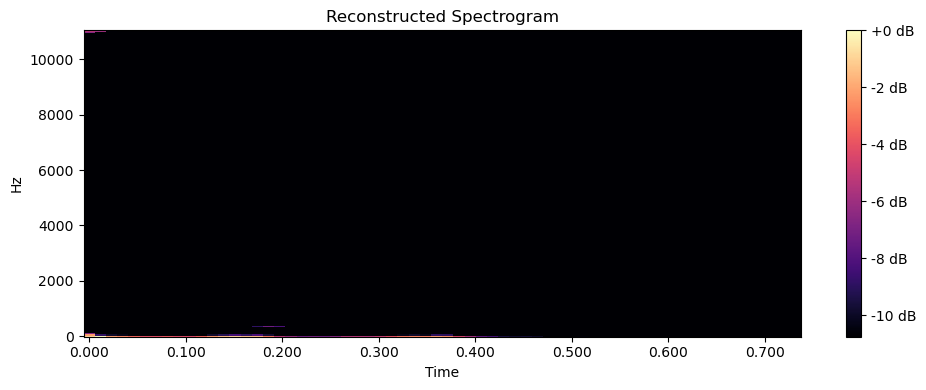

In [101]:
def generate_music(prior, decoder, n_samples):
    z = prior.sample(n_samples)
    return decoder(z).mean()

n_samples = 5
sm = generate_music(prior, decoder, n_samples)
reconstruct_audio(sm[1], "originalu.wav", -80, 0)

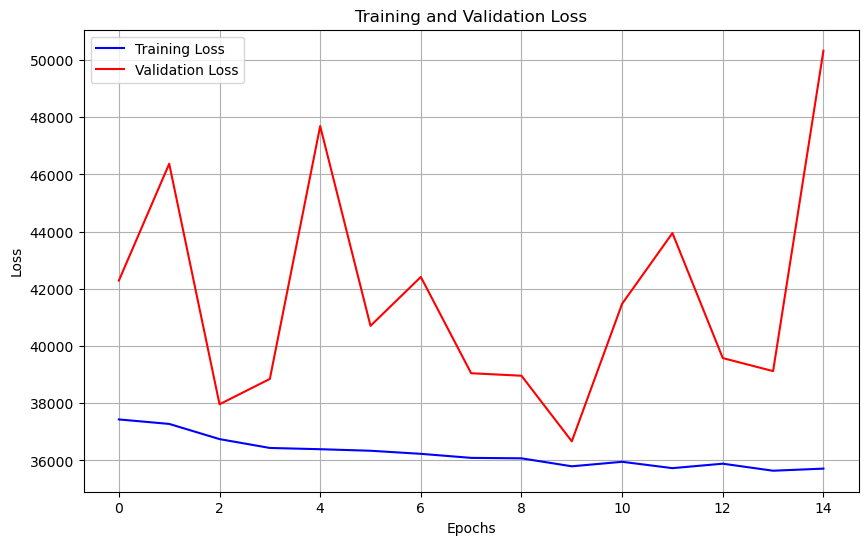

In [102]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']  # Training loss
val_loss = history.history.get('val_loss', [])  # Validation loss, if available

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='b')
if val_loss:  # Plot validation loss if provided
    plt.plot(val_loss, label='Validation Loss', color='r')

plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.title('Training and Validation Loss')  # Plot title
plt.legend()  # Display the legend
plt.grid(True)  # Add gridlines
plt.show()  # Display the plot

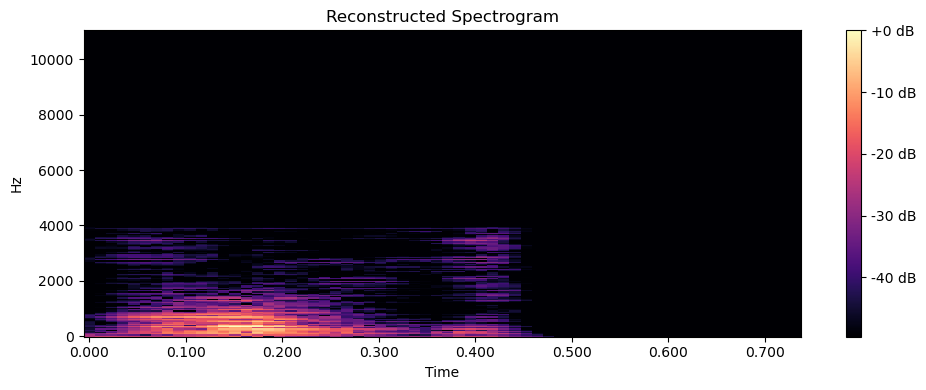

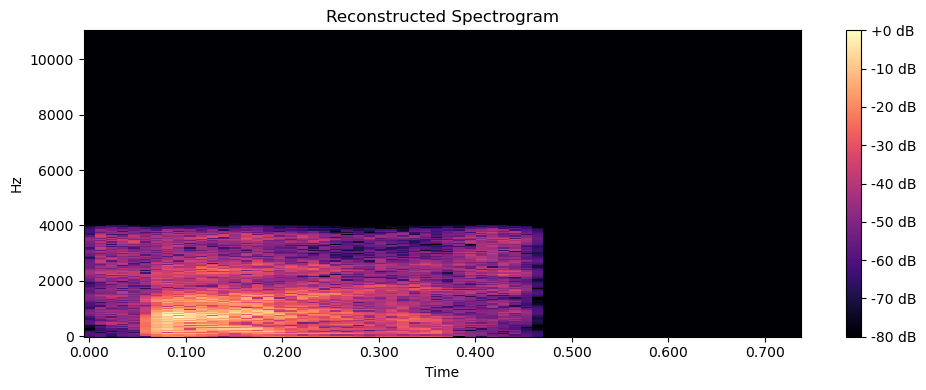

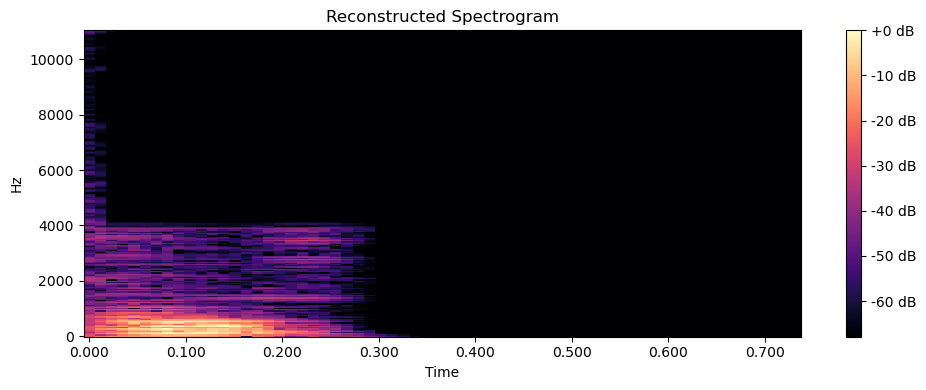

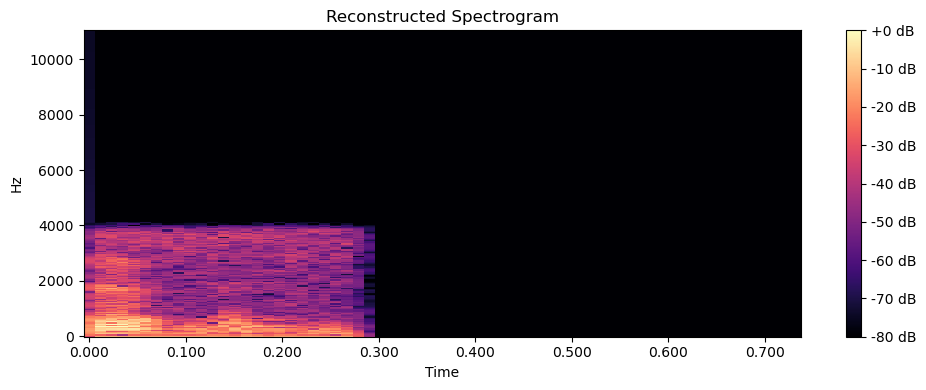

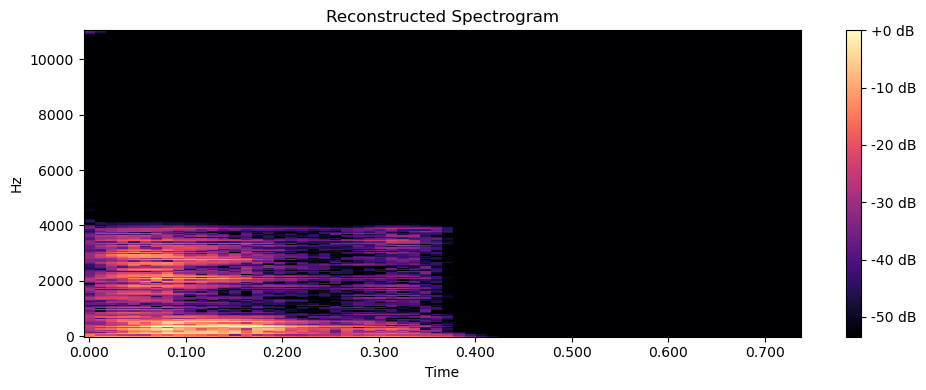

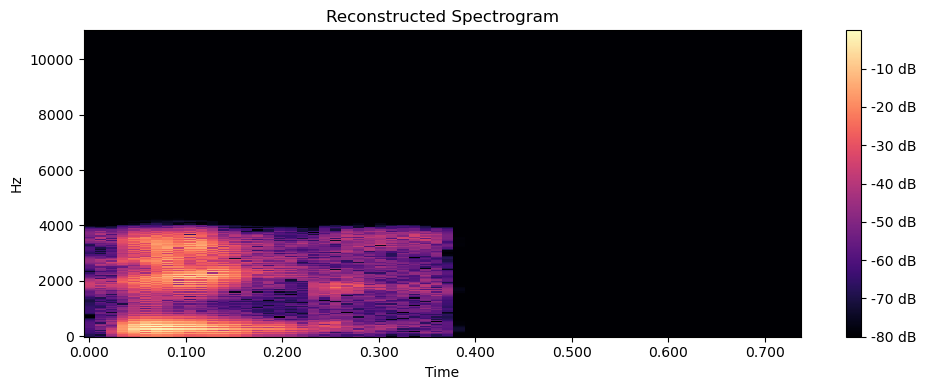

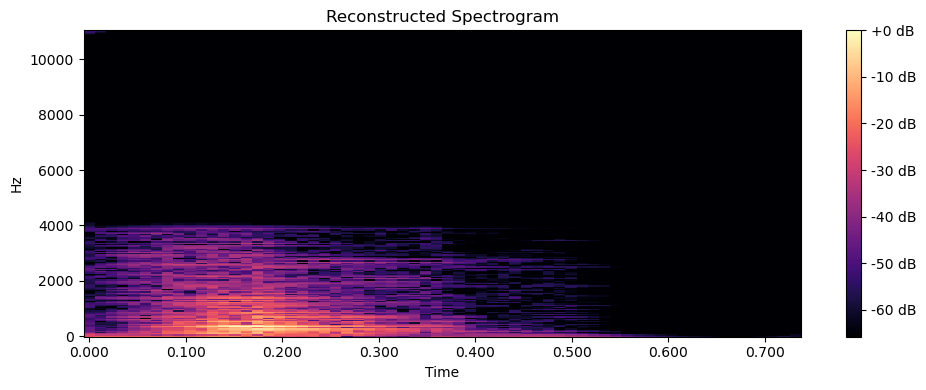

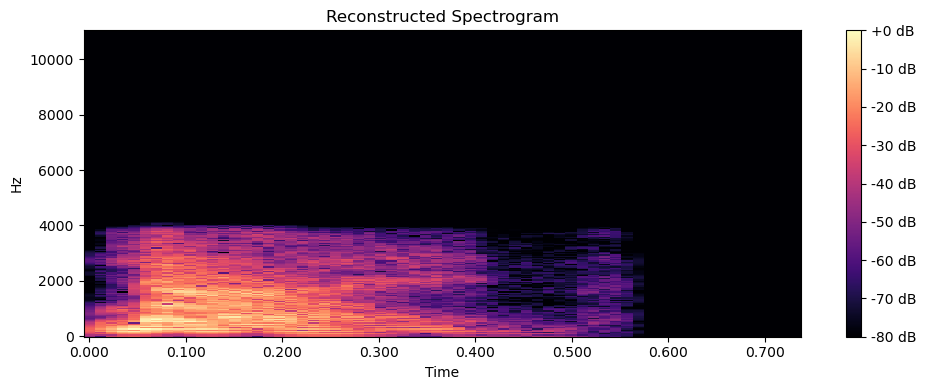

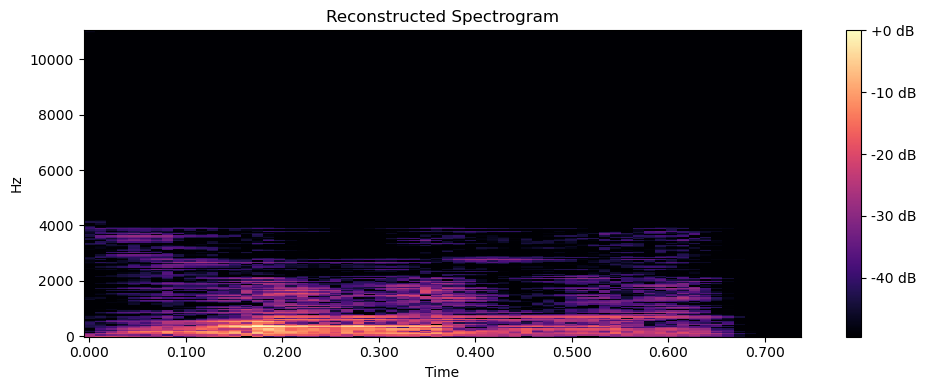

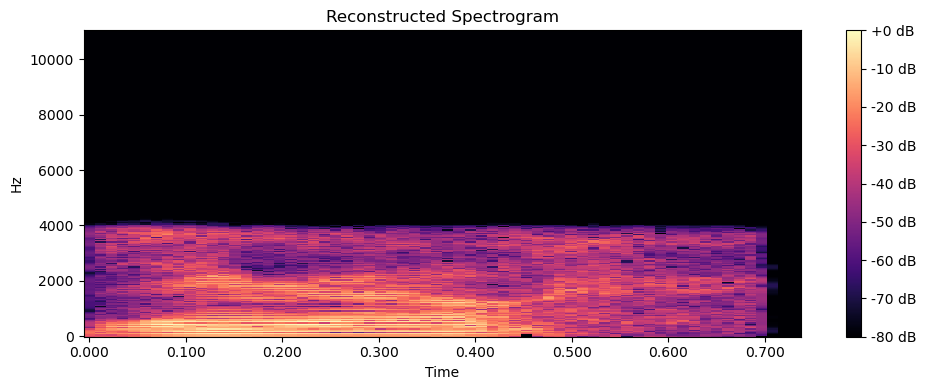

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

def reconstruct(encoder, decoder, batch_of_images):
    latent_representations = encoder(batch_of_images)  
    distribution = decoder(latent_representations)  
    reconstructed_image_tensor = distribution.mean()  
    return reconstructed_image_tensor

n_reconstructions = 5
keys = list(randomized_dict.keys())
random_keys = np.random.choice(keys, n_reconstructions, replace=False)
batch_of_images = np.array([randomized_dict[key] for key in random_keys])
reconstructions = reconstruct(encoder, decoder, batch_of_images)
reconstructed_images_np = reconstructions.numpy()

def compare_reconstructed(reconstructed_images_np, min_max_dict, random_keys):
    for i, image in enumerate(reconstructed_images_np):
        file_name = random_keys[i]
        base_file_name = os.path.splitext(file_name)[0]

        min_val = min_max_dict[base_file_name]['min']
        max_val = min_max_dict[base_file_name]['max']

        reconstruct_audio(image, f"reconstructed_{file_name}.wav", min_val, max_val)
        reconstruct_audio(randomized_dict[file_name], f"original_{file_name}.wav", min_val, max_val)

min_max_dict = np.load('min_max_values.npy', allow_pickle=True).item()
compare_reconstructed(reconstructed_images_np, min_max_dict, random_keys)

In [ ]:
def compare_reconstructed(reconstructed_images_np, min_max_dict):
    for image in reconstructed_images_np:
        min_val = min_max_dict[file_name]['min']
        max_val = min_max_dict[file_name]['max']
        reconstruct_audio(image,f"{file_name}.wav",  min_val, max_val)
        reconstruct_audio(randomized_dict[file_name],f"{file_name}.wav",  min_val, max_val)

min_max_dict = np.load('min_max_values.npy', allow_pickle=True).item()
compare_reconstructed(reconstructed_images_np, min_max_dict)

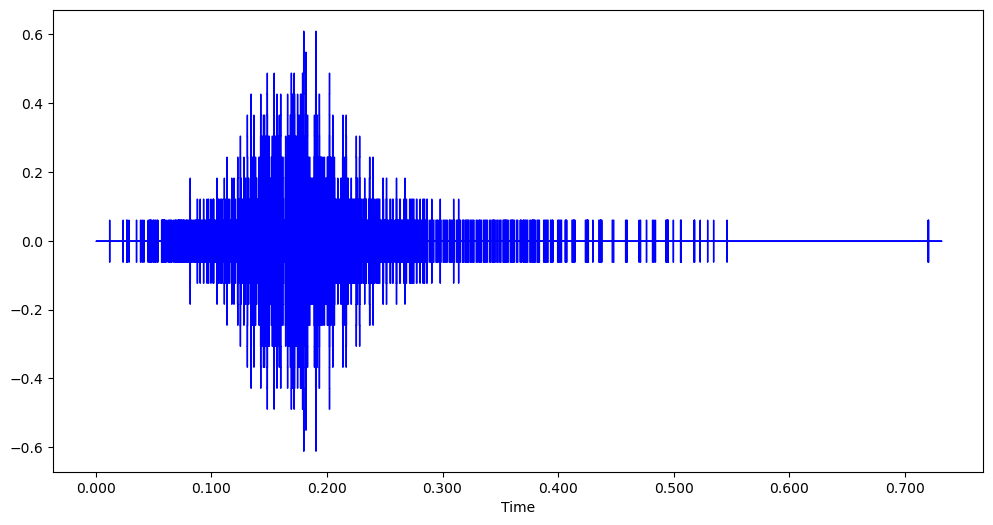

In [119]:
import librosa
import soundfile as sf
import numpy as np

# Load the audio file
audio_path = 'reconstructed_9_theo_26.npy.wav'
audio_data, sample_rate = librosa.load(audio_path, sr=None)

# Amplification factor (e.g., 1.5 to increase by 50%, 2.0 to double the amplitude)
amplification_factor = 2000
# Amplify the audio by scaling the amplitude
amplified_audio = audio_data * amplification_factor

# Ensure the amplified audio does not exceed the range [-1, 1] (clip if necessary)
amplified_audio = np.clip(amplified_audio, -1, 1)  # Prevent clipping/distortion

plt.figure(figsize=(12, 6))  # Set the figure size
librosa.display.waveshow(amplified_audio, sr=sample_rate, color='b') 

output_path = 'amplified_audio.wav'
sf.write(output_path, amplified_audio, sample_rate)

In [109]:
audio_path = 'eureka2.wav'
audio_data, sample_rate = librosa.load(audio_path, sr=None)  # Load audio with original sample rate

# Create a plot to visualize the waveform
plt.figure(figsize=(12, 6))  # Set the figure size
librosa.display.waveshow(audio_data, sr=sample_rate, color='b') 

C:\Users\mayal\AppData\Local\Temp\ipykernel_27908\1674483734.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(audio_path, sr=None)  # Load audio with original sample rate


FileNotFoundError: [Errno 2] No such file or directory: 'eureka2.wav'

In [97]:
vae.save('vae_model.keras')